# Homework 7 Template

Rixin Li & G . Besla

look for "****"

In [2]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbolszz
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass 


# M33AnalyticOrbit

In [66]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """ Inputs:
                self - the particular instance of the class itself
                filename - the file where the integrated orbit will be stored"""

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name  
        self.filename = filename
        
        ### get the current pos/vel of M33    
        # **** create an instance of the  CenterOfMass class for M33 
        M33COM = CenterOfMass('M33_000.txt',2)
        
        
        # **** store the position VECTOR of the M33 COM (.value to get rid of units) 
        M33COMP = M33COM.COM_P(0.1,4)
        
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        M33COMV = M33COM.COM_V(M33COMP[0],M33COMP[1],M33COMP[2]).value
        
        M33COMP = M33COMP.value
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        M31COM = CenterOfMass('M31_000.txt',2)

        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        M31COMP = M31COM.COM_P(0.1,2)

        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        M31COMV = M31COM.COM_V(M31COMP[0],M31COMP[1],M31COMP[2]).to(u.kpc/u.Gyr).value
        
        M31COMP = M31COMP.value
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = M33COMP - M31COMP
        self.v0 = M33COMV - M31COMV
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5 # in kpc
        
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = (ComponentMass('M31_000.txt',2)*1e12).value # disk mass in Msun
        
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1 # in kpc

        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = (ComponentMass('M31_000.txt',1)*1e12).value # bulge mass in Msun
        
        # Halo
        # **** self.rhalo = set scazle length from HW5 (no units)
        self.rhalo = 62 # in kpc (determined in Homework 5)

        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = (ComponentMass('M31_000.txt',1)*1e12).value # halo mass in Msun 
    
    
    def HernquistAccel(self,M,ra,r): # it is easiest if you take as an input the position VECTOR 
        """Function to compute the gravitational acceleration vector from halo and 
        bulge as determined by Hernquist profile
            Inputs: 
                M - total halo or bulge mass in Msun
                ra - scale length in kpc
                r - relative position vector in kpc
            Returns:
                Hernquist acceleration vector in kpc/Gyr^2"""
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
        
        ### *** Store the Acceleration
        Hern =  -self.G * M/(rmag*(ra+rmag)**2)*r #follow the formula in the HW instructions
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self,M,rd,r):# it is easiest if you take as an input a position VECTOR  r 
        # Function to compute gravitational acceleration vector from disk as determined 
        # by Miyamoto - Nagai profile
        # Inputs: 
            # M - total disk mass in Msun
            # rd - scale length in kpc
            # r - relative position vector in kpc
        # Returns:
            # Miyamoto-Nagai acceleration vector in kpc/Gyr^2

        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        R = np.sqrt(r[0]**2+r[1]**2)
        zd = rd/5.0
        B = rd + np.sqrt(r[2]**2+zd**2)
        Mayaprelim = -self.G * M / (R**2+B**2)**1.5 * r
        Maya = Mayaprelim * np.array([1,1,B/np.sqrt(r[2]**2+zd**2)])


        return Maya
        # the np.array allows for a different value for the z component of the acceleration

    
    def M31Accel(self,r): # input should include the position vector, r
        """Function to combine accelerations from all components of galaxy
            Inputs: 
                r - relative position vector in kpc
            Returns: 
                net acceleration vector in kpc/Gyr^2"""

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        ahalo = self.HernquistAccel(self.Mhalo,self.rhalo,r)
        abulge = self.HernquistAccel(self.Mbulge,self.rbulge,r)
        adisk = self.MiyamotoNagaiAccel(self.Mdisk,self.rdisk,r)
            
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return ahalo + abulge + adisk
    
    
    
    def LeapFrog(self,dt,r,v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ Function which performs Leap Frog integration scheme 
            Inputs: 
                dt - time step in Gyr
                r - starting relative position vector in kpc
                v - starting relative velocity vector in kpc/Gyr
            Returns:
                new position and velocity vectors after time step dt"""
        
        # predict the position at the next half timestep
        rhalf = r + v*dt/2.0
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)*dt  
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = r + (v + vnew)*dt/2.0
        
        return rnew, vnew # **** return the new position and velcoity vectors
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):   
         # Function to loop over Leap Frog integration function, solving equations of motion and computing 
         # the future orbit of M33
             # Inputs: 
                 # t0 - initial time in Gyr
                 # dt - time interval in Gyr
                 # tmax - final time in Gyr
            # Returns:
                 # file containing predicted position and velocity vectors as a function of time 

            # initialize the time to the input starting time
            t = t0

            # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
            orbit = np.zeros([int(tmax/dt)+2,7]) 

            # initialize the first row of the orbit
            orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
            # this above is equivalent to 
            # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]

            # initialize position and velocity
            r = self.r0
            v = self.v0

            # initialize a counter for the orbit.  
            i = 1 # since we already set the 0th values, we start the counter at 1

            # start the integration (advancing in time steps and computing LeapFrog at each step)
            while (t <= tmax):  # as long as t has not exceeded the maximal time 

                # **** advance the time by one timestep, dt
                t = t + dt
                # **** store the new time in the first column of the ith row
                orbit[i][0] = t

                # ***** advance the position and velocity using the LeapFrog scheme
                # remember that LeapFrog returns a position vector and a velocity vector  
                # as an example, if a function returns three vectors you would call the function and store 
                # the variable like:     a,b,c = function(input)
                r,v = self.LeapFrog(dt,r,v)

                # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
                # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
                # A[n, 5:8] 
                # where the syntax is row n, start at column 5 and end BEFORE column 8
                orbit[i,1:4] = r

                # ****  store the new position vector into the columns with indexes 4,5,6 of the ith row of orbit
                orbit[i,4:7] = v

                # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
                i = i +1 


            # write the data to a file
            np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                       header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                       .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

            # there is no return function

In [67]:
M33AnalyticOrbit = M33AnalyticOrbit('AnalyticOrbit_M33.txt')

In [104]:
M33AnalyticOrbit.OrbitIntegration(0,0.0001,10)  

In [105]:
# Read in the data files for the orbits of each galaxy that you just created
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt

M31data = np.genfromtxt('Orbit_M31.txt',dtype=None,names=True)
M33data = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True)
M33AnalyticData = np.genfromtxt('AnalyticOrbit_M33.txt',dtype=None,names=True)

In [106]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  

def magdiff(ax,ay,az,bx,by,bz):
    return np.sqrt((ax-bx)**2+(ay-by)**2+(az-bz)**2)

In [107]:
# Determine the magnitude of the relative position and velocities using simulation data

M31x = M31data['x']
M31y = M31data['y']
M31z = M31data['z']

M31vx = M31data['vx']
M31vy = M31data['vy']
M31vz = M31data['vz']

M33x = M33data['x']
M33y = M33data['y']
M33z = M33data['z']

M33vx = M33data['vx']
M33vy = M33data['vy']
M33vz = M33data['vz']

M31M33relpos = magdiff(M31x,M31y,M31z,M33x,M33y,M33z)
M31M33relvel = magdiff(M31vx,M31vy,M31vz,M33vx,M33vy,M33vz)

# Using analytic data
M31M33relposanalytic = np.sqrt(M33AnalyticData['x']**2+M33AnalyticData['y']**2+M33AnalyticData['z']**2)
M31M33relvelanalytic = np.sqrt(M33AnalyticData['vx']**2+M33AnalyticData['vy']**2+M33AnalyticData['vz']**2)


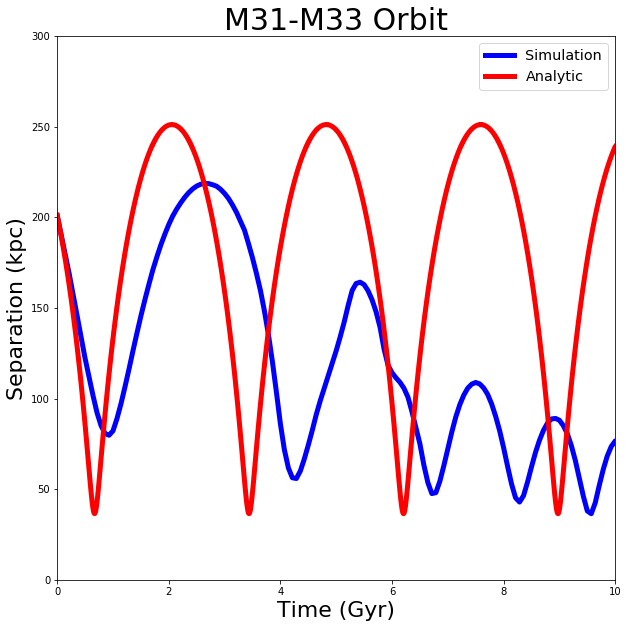

In [108]:
# Plot the Orbit of M31 - M33
#################################
 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot relative position between M31 and M33
plt.plot(M31data['t'],M31M33relpos,color='blue',linewidth=5,label='Simulation')
plt.plot(M33AnalyticData['t'],M31M33relposanalytic,color='red',linewidth=5,label='Analytic')

# Add chart title 
plt.title('M31-M33 Orbit',fontsize=30)

# Add axis labels
plt.xlabel('Time (Gyr)',fontsize=22)
plt.ylabel('Separation (kpc)',fontsize=22)

# set axis limits
plt.xlim(0,10)
plt.ylim(0,300)


# add a legend
legend = ax.legend(loc='upper right',fontsize='x-large')

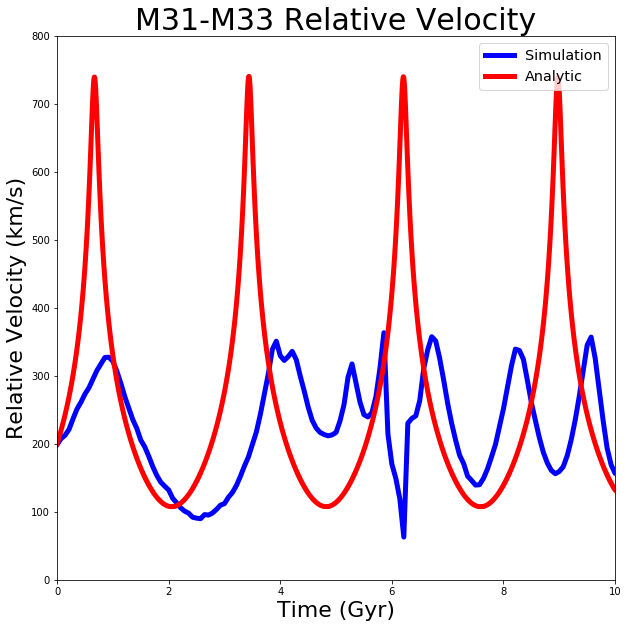

In [109]:
# Plot the orbital velocity of M31 - M33 
#################################

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot relative position between MW and M31
plt.plot(M31data['t'],M31M33relvel,color='blue',linewidth=5,label='Simulation')
plt.plot(M33AnalyticData['t'],M31M33relvelanalytic,color='red',linewidth=5,label='Analytic')

# Add chart title 
plt.title('M31-M33 Relative Velocity',fontsize=30)

# Add axis labels
plt.xlabel('Time (Gyr)',fontsize=22)
plt.ylabel('Relative Velocity (km/s)',fontsize=22)

# set axis limits
plt.xlim(0,10)
plt.ylim(0,800)


# add a legend
legend = ax.legend(loc='upper right',fontsize='x-large')

In [110]:
# 2. Analytic plots show very regular motion of M33 around M31. Simulation plots show more irregular patterns,
#    especially after merger event. Moreover, simulation results show decay of orbit after merger event. 

In [111]:
# 3. The gravitational effects of the MW were not taken into account, much less the MW-M31 merger event.

In [112]:
# 4. Could find acceleration of M33 due to MW in same way we did for M31. Should also probably evolve M31's orbit 
#    as a result of MW's influence. 